# Text Classification of IMDB Dataset

***

## Contents
1. [Overview](#overview)
2. [Data Preprocessing](#preprocess)
3. [Modelling (sklearn)](#sklearn)
4. [Modelling (BERT)](#bert)
5. [Conclusion](#conclusion)

***

<a id = 'overview'></a>
### 1. *Overview*
In this notebook we will be exploring the [IMDB dataset](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) available on Kaggle, containing 50,000 reviews categorised as either positive or negative reviews. Simple text classification models will be built using sklearn to serve as a baseline, while an additional model will be built using BERT as comparison to the different models' performances.

***


In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import string
import re
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as snspip
import plotly.io as pio
import plotly.express as px
import plotly.figure_factory as ff
pio.renderers.default = 'svg'

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

from pytorch_transformers import RobertaModel, RobertaTokenizer
from pytorch_transformers import RobertaForSequenceClassification, RobertaConfig

import tensorflow as tf
import tensorflow_hub as hub
import bert
import random
import math
from tensorflow.keras import layers

***
<a id = 'preprocess'></a>
### 2. *Data Preprocessing*

In [2]:
# Read data
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# Check class imbalance
df.sentiment.value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [4]:
# Check missing values
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [5]:
# Categorise sentiments
df.loc[df.sentiment == 'positive', 'sentiment'] = 1
df.loc[df.sentiment == 'negative', 'sentiment'] = 0

# Lemmatize words, remove stopwords and punctuations
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

lemmatizer = WordNetLemmatizer()

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(lemmatizer.lemmatize(i.strip().lower()))
    return " ".join(final_text)

def cleantext(text):
    text = strip_html(text)
    text = remove_stopwords(text)
    return text
df['review'] = df['review'].apply(cleantext)
df.head()

,review,sentiment
0,one reviewer mentioned watching oz episode exa...,1
1,wonderful little filming technique fashion giv...,1
2,thought wonderful way spend time hot summer si...,1
3,basically family little boy think zombie close...,0
4,petter time visually stunning film mattei offe...,1


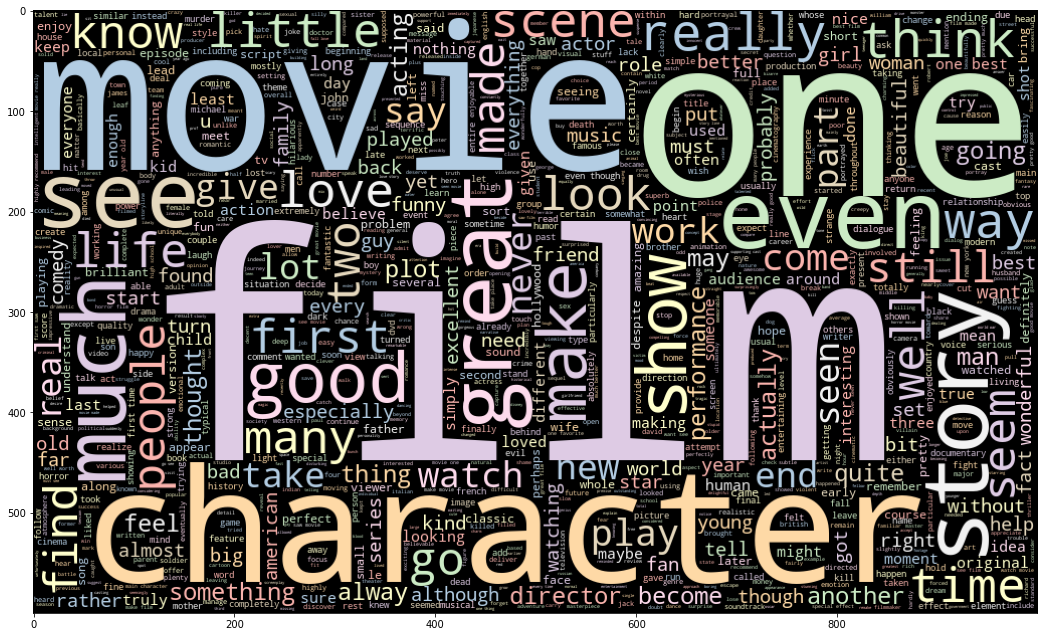

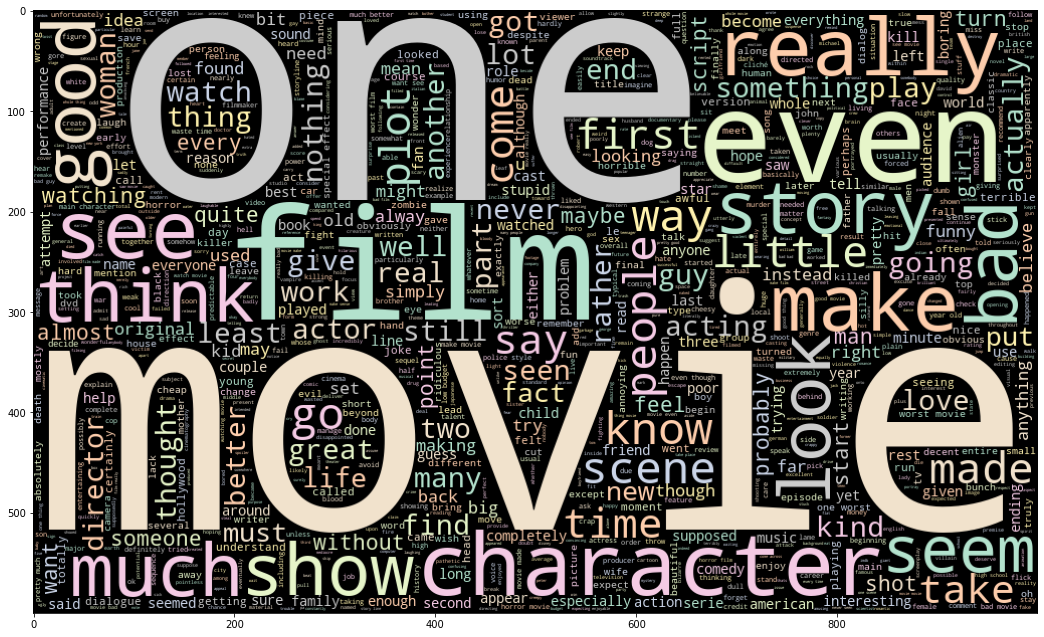

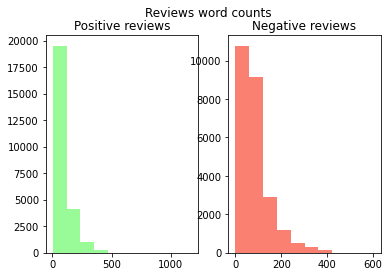

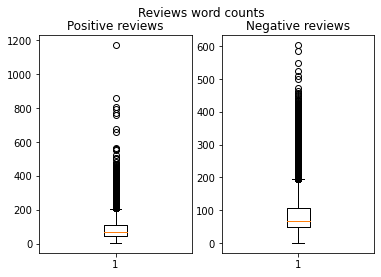

In [6]:
# Plot wordclouds of the different sentiments
# positive
plt.figure(figsize = (18,18))
wc = WordCloud(max_words = 1000, width = 1000, height = 600, colormap = 'Pastel1').generate(" ".join(df[df.sentiment == 1].review))
plt.imshow(wc)

# negative
plt.figure(figsize = (18,18))
wc = WordCloud(max_words = 1000, width = 1000, height = 600, colormap = 'Pastel2').generate(" ".join(df[df.sentiment == 0].review))
plt.imshow(wc)

# Plot wordcount of the different sentiments
# positive
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Reviews word counts')
ax1.hist(df[df['sentiment'] == 1]['review'].str.split().map(lambda x: len(x)), color = 'palegreen')
ax1.set_title('Positive reviews')
ax2.hist(df[df['sentiment'] == 0]['review'].str.split().map(lambda x: len(x)), color = 'salmon')
ax2.set_title('Negative reviews')
plt.show()

# negative
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Reviews word counts')
ax1.boxplot(df[df['sentiment'] == 1]['review'].str.split().map(lambda x: len(x)))
ax1.set_title('Positive reviews')
ax2.boxplot(df[df['sentiment'] == 0]['review'].str.split().map(lambda x: len(x)))
ax2.set_title('Negative reviews')
plt.show()

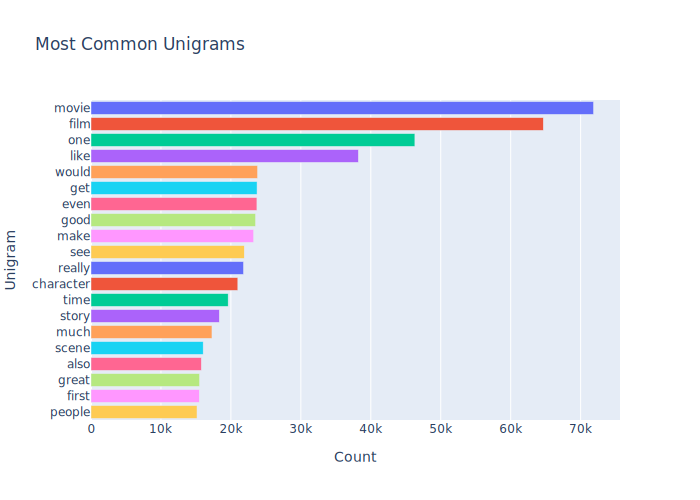

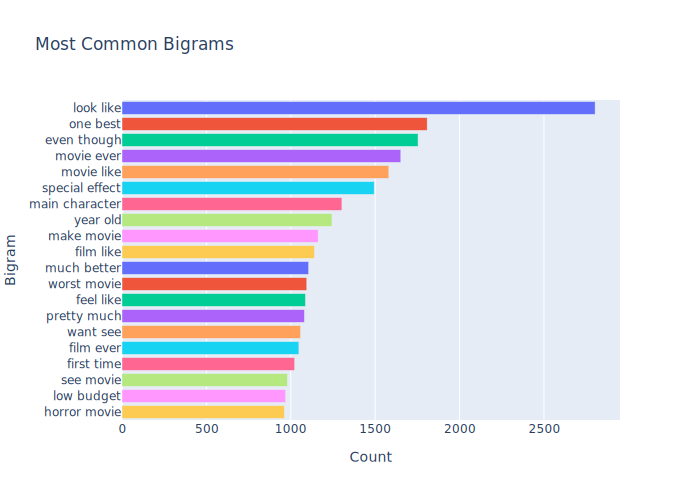

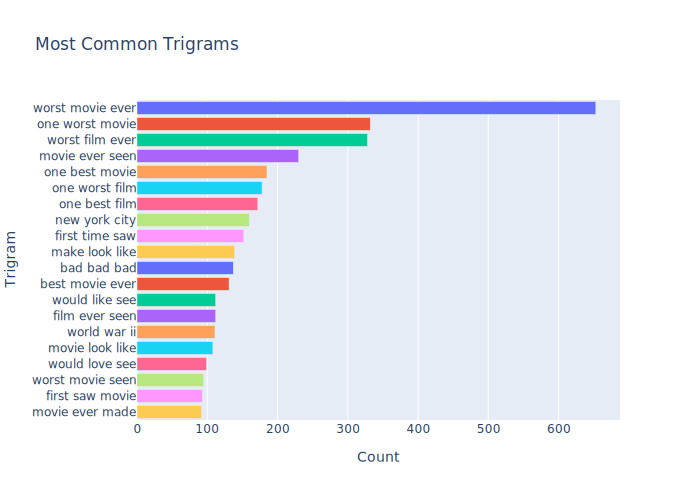

In [7]:
# Create a corpus
corpus = []
for i in df.review:
    for j in i.split():
        corpus.append(j.strip())

counter_words = Counter(corpus)

# Words that appear the most
counter_top10 = counter_words.most_common(10)

# Function to find ngrams that appear the most
def most_common_ngrams(corpus, n, gram):
    vec = CountVectorizer(ngram_range = (gram, gram)).fit(corpus)
    bow = vec.transform(corpus)
    word_sum = bow.sum(axis=0)
    word_freq = [(word, word_sum[0, idx]) for word, idx in vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse = True)
    return word_freq[:n]

# Function to plot 'most_common_ngrams'
def plot_ngram(corpus, n, gram, name):
    top_ngram = most_common_ngrams(corpus, n, gram)
    top_ngram = dict(top_ngram)
    tmp = pd.DataFrame(columns = [str(name), 'Count'])
    tmp[str(name)] = list(top_ngram.keys())
    tmp['Count'] = list(top_ngram.values())
    fig = px.bar(tmp, x = 'Count', y = str(name), title = "Most Common "+str(name)+"s", orientation = 'h',
                 color = str(name))
    fig.update_layout(showlegend=False)
    fig.show()

# Plot most common unigram    
plot_ngram(df.review, 20, 1, "Unigram")

# Plot most common bigram    
plot_ngram(df.review, 20, 2, "Bigram")

# Plot most common trigram    
plot_ngram(df.review, 20, 3, "Trigram")

***
<a id = 'sklearn'></a>
### 3. *Modelling (sklearn)*
In this section we will build and compare three models using Logistic Regression, Linear Support Vector Classifier, and Multinomial Naive Bayes.

In [8]:
# TFIDF Vectorizer using ngrams range 1 to 3
tfidf_vect = TfidfVectorizer(analyzer = 'word', ngram_range = (1,3))
tfidf_vect.fit(df.review)

features = tfidf_vect.fit_transform(df.review)
labels = df.sentiment

# Train test split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.1, random_state = 33)
y_train, y_test = y_train.astype('int'), y_test.astype('int')

# Initialise models
logreg = LogisticRegression(random_state = 33)
svc = LinearSVC(random_state = 33)
mnb = MultinomialNB()

# Function to train model, make predictions, and evaluate model
def model_pred(clf, x_train, x_test, y_train, y_test):
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    con_matrix = confusion_matrix(y_test, pred)
    print(str(clf))
    print(' Accuracy :', acc)
    print(' F1 :', f1)
    print(' Confusion Matrix :\n', con_matrix)
    return pred, acc, f1, con_matrix

logreg_pred, logreg_acc, logreg_f1, logreg_con = model_pred(logreg, x_train, x_test, y_train, y_test)
svc_pred, svc_acc, svc_f1, svc_con = model_pred(svc, x_train, x_test, y_train, y_test)
mnb_pred, mnb_acc, mnb_f1, mnb_con = model_pred(mnb, x_train, x_test, y_train, y_test)


LogisticRegression(random_state=33)
 Accuracy : 0.8724
 F1 : 0.871938980329185
 Confusion Matrix :
 [[2190  343]
 [ 295 2172]]
LinearSVC(random_state=33)
 Accuracy : 0.892
 F1 : 0.8912167606768735
 Confusion Matrix :
 [[2248  285]
 [ 255 2212]]
MultinomialNB()
 Accuracy : 0.883
 F1 : 0.8821752265861027
 Confusion Matrix :
 [[2225  308]
 [ 277 2190]]


From the above we observe that the three models have similar performances with LinearSVC having the best performance of 89.2% accuracy and an f1 score of 0.891. This shall serve as the comparison for the XLNet model that will be built in the following section.

***

<a id = 'bert'></a>
### 4. *Modelling (BERT)*
In this section the tensorflow implementation of a pretrained BERT model will be used to tokenize the reviews before the CNN model is built.

In [27]:
# Create BERT tokenizer
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable = False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocab_file, lower_case)

In [28]:
# Function to tokenize texts
def tokenize_texts(texts):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts))

tokenized_texts = [tokenize_texts(review) for review in df.review]

In [29]:
# Obtain length of review
reviews_with_length = [[review, df.sentiment[i], len(review)] for i, review in enumerate(tokenized_texts)]

# Shuffle and sort by length
random.shuffle(reviews_with_length)
reviews_with_length.sort(key = lambda x: x[2])
sorted_reviews = [(review[0], review[1]) for review in reviews_with_length]

# Convert data to use as input for Tensorflow
tf_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews, output_types=(tf.int32, tf.int32))

In [30]:
# Split dataset into batches and pad to same length
BATCH_SIZE = 32
batched_dataset = tf_dataset.padded_batch(BATCH_SIZE, padded_shapes = ((None, ), ()))

# Train test split
total_batches = math.ceil(len(sorted_reviews)/BATCH_SIZE)
test_batches = total_batches // 10
batched_dataset.shuffle(total_batches)
test_data = batched_dataset.take(test_batches)
training_data = batched_dataset.skip(test_batches)

In [13]:
# Create model class
class TEXT_MODEL(tf.keras.Model):
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions = 128,
                 cnn_filters = 50,
                 dnn_units = 512,
                 model_output_classes = 2,
                 dropout_rate = 0.1,
                 training = False,
                 name = "text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                        embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units = 1,
                                          activation = "sigmoid")
        else:
            self.last_dense = layers.Dense(units = model_output_classes,
                                          activation = "softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l)
        l_1 = self.pool(l_1)
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis = -1)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        return model_output
    
# Initialise hyperparameters
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2
DROPOUT_RATE = 0.2
NB_EPOCHS = 5

# Create model
text_model = TEXT_MODEL(VOCAB_LENGTH, EMB_DIM, CNN_FILTERS, DNN_UNITS, OUTPUT_CLASSES, DROPOUT_RATE)
text_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [14]:
# Fitting model
text_model.fit(training_data, epochs = NB_EPOCHS)

Epoch 1/5
1407/1407 [==============================] - 152s 106ms/step - loss: 0.3600 - accuracy: 0.8353
Epoch 2/5
1407/1407 [==============================] - 74s 52ms/step - loss: 0.1563 - accuracy: 0.9407
Epoch 3/5
1407/1407 [==============================] - 76s 54ms/step - loss: 0.0668 - accuracy: 0.9761
Epoch 4/5
1407/1407 [==============================] - 84s 59ms/step - loss: 0.0434 - accuracy: 0.9842
Epoch 5/5
1407/1407 [==============================] - 80s 56ms/step - loss: 0.0311 - accuracy: 0.9894


In [31]:
# Evaluation
results = text_model.evaluate(test_data)
print(results)

156/156 [==============================] - 1s 8ms/step - loss: 0.8090 - accuracy: 0.8464
[0.8089609742164612, 0.8463541865348816]


The BERT model achieves an accuracy of 84.6%, slightly lower than the performance seen in the sklearn models.

***

<a id = 'bert'></a>
### 5. *Conclusion*
In this notebook we explored different approaches to text classification on the IMDB Dataset, utilising the default/basic settings for sklearn/bert we observe that LinearSVC has the best performance. Further tests can be conducted by fine tuning these models (i.e. hyperparameters tuning, word embeddings, etc.) to conduct a fairer comparison on the text classification performances these models are capable of achieving.